In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import scipy.io as sio 


In [2]:
data = sio.loadmat('data/bretigny_seg.mat')

In [3]:
data['HV'] = np.sqrt(2) * data['HV']
#power conservation

In [4]:
height, length = data['HH'].shape

In [5]:
img = np.zeros((height, length,3), dtype= np.complex128)

In [6]:
for i in range(height) :
    for j in range(length) :
        img[i,j] = [data['HH'][i,j], data['HV'][i,j], data["VV"][i,j]]

In [7]:
formated_img = img[50:1400, 50:3340]

In [ ]:
img[:3,:3]@np.ones((3,1))

array([[[-0.31967118-0.06111267j],
        [-0.22184855-0.03938631j],
        [ 0.05127944-0.07868176j]],

       [[ 0.12070337-0.10440514j],
        [-0.02185535-0.01050185j],
        [-0.11505196+0.0253333j ]],

       [[ 0.20868319-0.03267166j],
        [ 0.13565296+0.08280683j],
        [-0.02224059+0.13393377j]]])

In [ ]:
np.mean([[[1,10],[1,10]],[[1,10],[1,10]],[[1,10],[1,10]]], axis =(0,1))

array([ 1., 10.])

In [8]:
var_0, var_1, var_2 = np.var(abs(formated_img[:,:,0].reshape(-1))), np.var(abs(formated_img[:,:,1].reshape(-1))), np.var(abs(formated_img[:,:,2].reshape(-1)))

In [ ]:
var_0, var_1, var_2

(2.8842578625316313, 0.16140958994903581, 1.2082411902338253)

In [ ]:
np.array([-1,-1])<np.array([0,0])

array([ True,  True])

In [9]:
#filter working as a grid adding all the given pixel
#basicall convolution over the whole image keeping the dimension of the original image
#Conclusion : filtrage par moyenne très mauvais pour ce qui est des zones à fortes variations comme peuvent l'être les centres urbains.

def apply_average_filter(img, kernel_size):
    
    filtered_img = np.zeros(img.shape, dtype = np.complex128)
    height, length, dim = img.shape

    k_height, k_length = kernel_size[0], kernel_size[1]

    filtered_img = np.zeros_like(img)

    for i in range(height) :
        for j in range(length) :
            top = max(0, i - k_height//2)
            bottom = min(height, i + k_height//2 + 1)
            left = max(0, j-k_length//2)
            right = min(length, j + k_length//2 + 1)
            filtered_img[i,j] = np.mean(img[top:bottom, left:right, :], axis = (0,1), dtype = complex)

    return filtered_img


def gauss(p,q, sigma2) :
    return 1/(2*np.pi* sigma2)* np.exp(-(p*p+q*q)/2/sigma2)


def apply_gauss_filter(img, kernel_size) :

    filtered_img = np.zeros_like(img)
    height, length, dim = img.shape

    k_height, k_length = kernel_size[0], kernel_size[1]
    for i in range(height) :
        for j in range(length) :
            top = max(0, i - k_height//2)
            bottom = min(height, i + k_height//2 + 1)
            range_h = bottom - top 
            left = max(0, j-k_length//2)
            right = min(length, j + k_length//2 + 1)
            range_l = right - left 
            filtered_img[i,j,0] = np.sum([img[top+p, left+q, 0]*gauss(p-i,q-j, var_0) for p in range(range_h) for q in range(range_l)], dtype = complex)
            filtered_img[i,j,1] = np.sum([img[top+p, left+q, 1]*gauss(p-i,q-j, var_1) for p in range(range_h) for q in range(range_l)], dtype = complex)
            filtered_img[i,j,2] = np.sum([img[top+p, left+q, 2]*gauss(p-i,q-j, var_2) for p in range(range_h) for q in range(range_l)], dtype = complex)
    return filtered_img

def img_gradient(img) :
    height, length, _ = img.shape
    grad_img = np.zeros((height, length, 2, 3), dtype=complex)

    grad_img[0,0,0] = img[1, 0] - img[0, 0]
    grad_img[0,0,1] = img[0, 1] - img[0, 0]

    grad_img[0, -1, 0] = img[1, -1] - img[0, -1]
    grad_img[0, -1, 1] = img[0, -1] - img[0, -2]

    grad_img[-1, 0, 0] = img[-2, 0] - img[-1, 0]
    grad_img[-1, 0, 1] = img[-1, 1] - img[-1, 0]

    grad_img[-1, -1, 0] = img[-1, -1] - img[-2, -1]
    grad_img[-1, -1, 1] = img[-1, -1] - img[-1, -2]

    for i in range(1, height - 1) :
        grad_img[i,0,0] = (img[i + 1, 0] - img[i - 1, 0]) /2
        grad_img[i,0,1] = img[i, 1] - img[i, 0]
        grad_img[i,-1,0] = (img[i + 1, -1] - img[i - 1, -1]) /2
        grad_img[i,-1,1] = img[i, -1] - img[i, -2]
    for j in range(1, length - 1) :
        grad_img[0,j,0] = (img[i+1, 0] - img[i-1,0]) /2
        grad_img[0,j,1] = (img[i, j+1] - img[i,j-1])
        grad_img[-1,j,0] = img[-1, j] - img[-2,j]
        grad_img[-1,j,1] = (img[-1, j+1] - img[-1,j-1])/2
    for i in range(height - 2):
        for j in range(length - 2) :
            grad_img[i+1,j+1][0] = (img[i+2,j+1] - img[i,j+1])/2
            grad_img[i+1,j+1][1] = (img[i+1,j+2] - img[i+1,j])/2
            
    return grad_img

# def key_pixels(img, neighbourhood = (3,3)) :
#     grad_img = img_gradient(img)
#     k_height, k_length = neighbourhood[0], neighbourhood[1]
#     for i in range(height) :
#         for j in range(length) :
#             if all(grad_img[i,j]<grad_img[i-k_height//2 : i+ k_height//2])

In [ ]:
filtered_img = apply_average_filter(img,(3,3))


In [ ]:
gauss_img = apply_gauss_filter(img,(3,3))

In [10]:
pauli_base_1 = 1/np.sqrt(2)*np.array([[1,0,1],[0,2,0],[1,0,-1]])
pauli_base_4 = 1/np.sqrt(2)*np.array([[1,0,1],[1,0,-1],[0,2,0]])
pauli_base_5 = 1/np.sqrt(2)*np.array([[1,0,-1],[1,0,1],[0,2,0]])
pauli_base_6 = 1/np.sqrt(2)*np.array([[1,0,-1],[0,2,0],[1,0,1]])
pauli_base_2 = 1/np.sqrt(2)*np.array([[0,2,0],[1,0,-1], [1,0,1]])
pauli_base_3 = 1/np.sqrt(2)*np.array([[0,2,0],[1,0,1],[1,0,-1]])
# the pauli base change is interchangeable with the mean convolution which is not the case with the median one
def rough_to_pauli(img, pauli_base) :
    height, length, dim = img.shape
    pauli_rough = np.zeros(img.shape,dtype = np.complex128)
    for i in range(height) :
        for j in range(length) :
            pauli_rough[i,j] = pauli_base@img[i,j]
    return pauli_rough

In [ ]:
formated_pauli_1 = rough_to_pauli(formated_img, pauli_base_1)
formated_pauli_2 = rough_to_pauli(formated_img, pauli_base_2)
formated_pauli_3 = rough_to_pauli(formated_img, pauli_base_3)
formated_pauli_4 = rough_to_pauli(formated_img, pauli_base_4)
formated_pauli_5 = rough_to_pauli(formated_img, pauli_base_5)
formated_pauli_6 = rough_to_pauli(formated_img, pauli_base_6)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


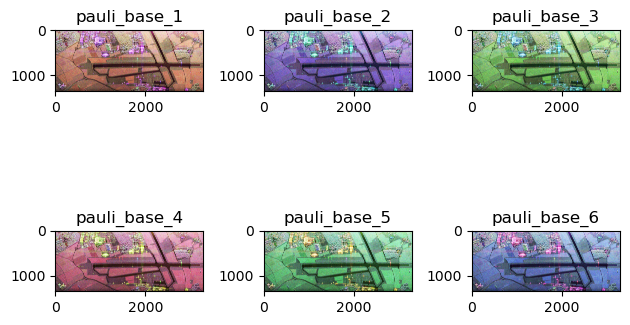

In [61]:
fig, ax = plt.subplots(2,3,squeeze=True)

ax[0,0].imshow(abs(formated_pauli_1))
ax[0,0].set_title('pauli_base_1')

ax[0,1].imshow(abs(formated_pauli_2))
ax[0,1].set_title('pauli_base_2')

ax[0,2].imshow(abs(formated_pauli_3))
ax[0,2].set_title('pauli_base_3')

ax[1,0].imshow(abs(formated_pauli_4))
ax[1,0].set_title('pauli_base_4')

ax[1,1].imshow(abs(formated_pauli_5))
ax[1,1].set_title('pauli_base_5')

ax[1,2].imshow(abs(formated_pauli_6))
ax[1,2].set_title('pauli_base_6')

fig.set_tight_layout(True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


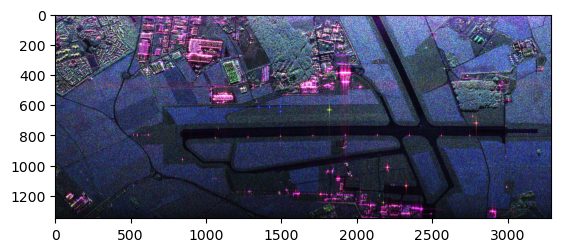

In [76]:
filtered_pauli = apply_average_filter(formated_pauli_6,(3,3))
plt.imshow(abs(filtered_pauli))

In [108]:
smooth_pauli = np.log(1+abs(filtered_pauli))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


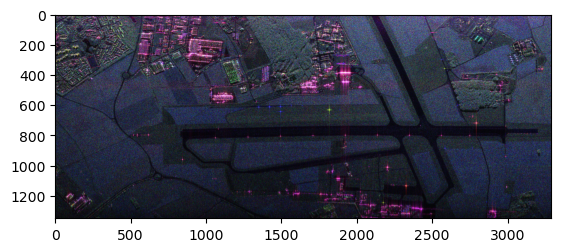

In [105]:
plt.imshow(np.log(1+np.log(1+abs(filtered_pauli))))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


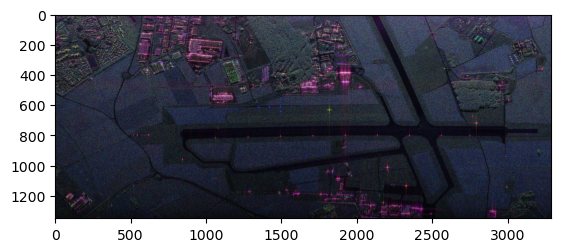

In [106]:
plt.imshow(np.log(1+np.log(1+np.log(1+abs(filtered_pauli)))))

**Data visualisation**
* We will keep the pauli_base_6 to represent our images as it gives better visual images with respect to the other base decomposition

In [ ]:
gauss_pauli = rough_to_pauli(gauss_img, pauli_base_6)

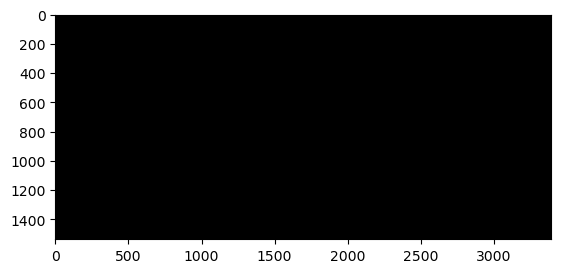

In [129]:
plt.imshow(abs(gauss_pauli))

In [135]:
grad_formated = img_gradient(formated_pauli_6)

In [138]:
def module(vect) :
    return np.sum([ abs(c) for c in vect])

In [145]:
grad_img = [[[module(grad_formated[i,j])]*3 for j in range(grad_formated.shape[1])]for i in range(grad_formated.shape[0])]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


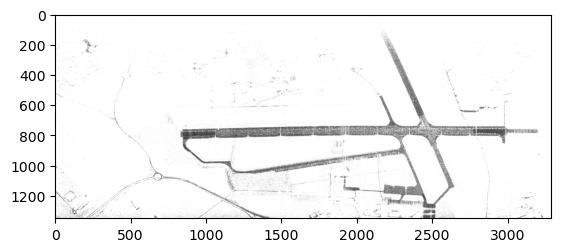

In [146]:
plt.imshow(grad_img)

**Train data**
* In order to reduce the time dedicated to training we offer to reduce the image to one of its subpart.
* We will be able to train on the whole image once we have a working code on the subpart.

In [11]:
#We can see that the information in areas that are darker on the side has been lost
#I offer to cut the image in its darkest parts basically on the top and the bottom
new_img = img[400:830,1500:2100]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


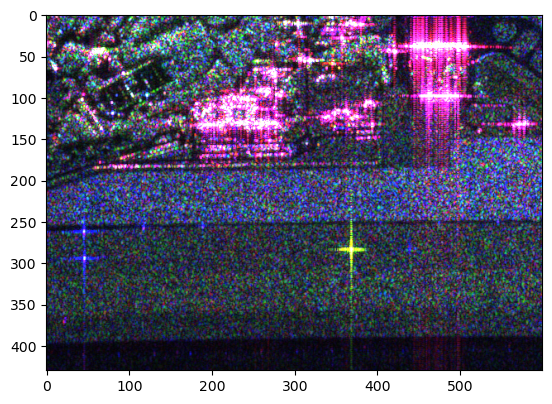

In [147]:
filtered_new_img = apply_average_filter(new_img, (3,3))
filtered_new_pauli = rough_to_pauli(filtered_new_img,pauli_base_6)
plt.imshow(abs(filtered_new_pauli))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


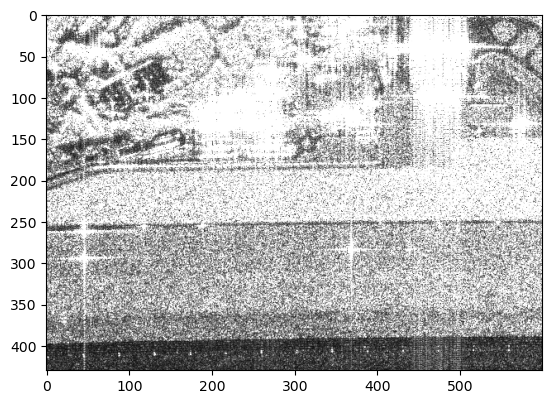

In [151]:
new_height, new_length = new_img.shape[:2]
score_img = np.zeros(new_img.shape, dtype = float)
for i in range(new_height) :
    for j in range(new_length) :
        score_img[i,j] = np.sqrt(abs(new_img[i,j,0])**2+abs(new_img[i,j,2])**2)
plt.imshow(score_img)

(array([24.,  6., 21., 21., 15., 24., 24., 12.,  9.,  9.,  9., 12., 12.,
        12.,  6.,  6., 15., 21., 18.,  9., 12.,  9.,  6.,  6.,  6.,  3.,
         9.,  9.,  9.,  3.]),
 array([100.        , 103.33333333, 106.66666667, 110.        ,
        113.33333333, 116.66666667, 120.        , 123.33333333,
        126.66666667, 130.        , 133.33333333, 136.66666667,
        140.        , 143.33333333, 146.66666667, 150.        ,
        153.33333333, 156.66666667, 160.        , 163.33333333,
        166.66666667, 170.        , 173.33333333, 176.66666667,
        180.        , 183.33333333, 186.66666667, 190.        ,
        193.33333333, 196.66666667, 200.        ]),
 <BarContainer object of 30 artists>)

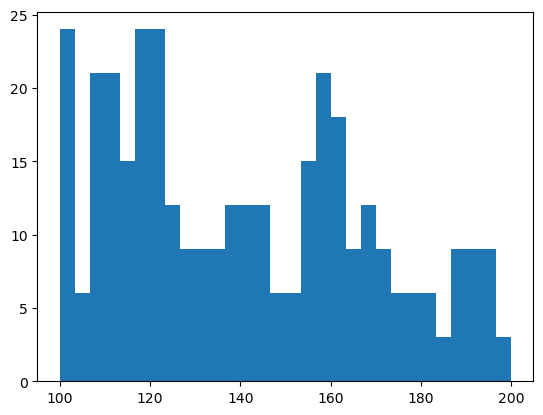

In [164]:
plt.hist(score_img.reshape(-1),30,range =(100,200))

In [178]:
speckle_points = score_img[:,:,0] > 30

In [179]:
score_img[speckle_points] = (100,0,0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


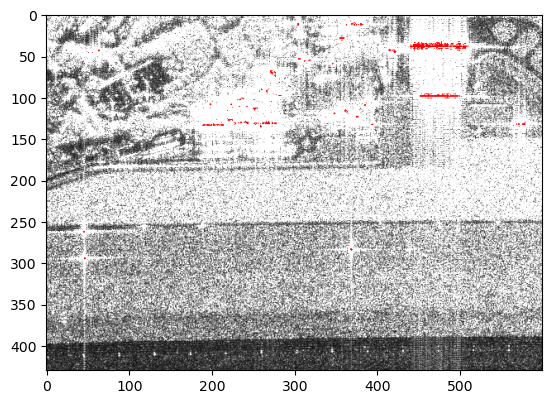

In [180]:
plt.imshow(score_img)

In [219]:
def despeckling(img) :
    score_img = np.zeros(img.shape[:2], dtype = float)
    new_img = img
    speckle_points_list = []
    for i in range(new_height) :
        for j in range(new_length) :
            if np.sqrt(abs(new_img[i,j,0])**2+abs(new_img[i,j,2])**2) >30 :
                speckle_points_list.append((i,j)) 

    for (p,q,d) , val in np.ndenumerate(img) :
        i,j = closest((p,q),speckle_points_list)
        new_img[p,q,d] = img[p,q,d]/(1+abs(np.sinc((abs(p-i)+1/2)))*abs(np.sinc((abs(q-j)+1/2)))*abs(img[i,j,d]))
    return new_img
def closest(point,list) :
    dist_list = []
    for i,j in list :
        dist_list.append(abs(i-point[0])+abs(j-point[1]))
    return list[np.argmin(dist_list)]



In [220]:
despeckled_img = despeckling(new_img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


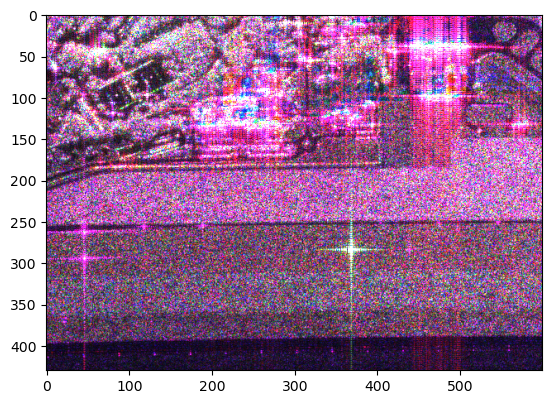

In [221]:
plt.imshow(abs(despeckled_img))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


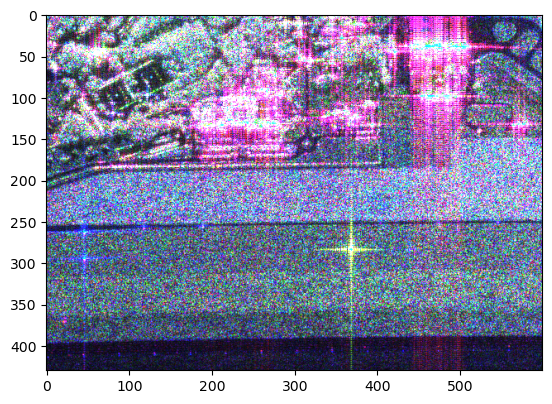

In [211]:
pauli = rough_to_pauli(new_img,pauli_base_6)
plt.imshow(abs(pauli))

In [212]:
new_filtered_img = apply_average_filter(pauli,(3,3))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


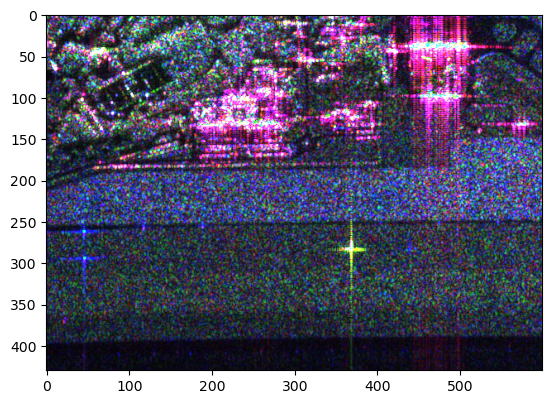

In [213]:
plt.imshow(abs(new_filtered_img))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


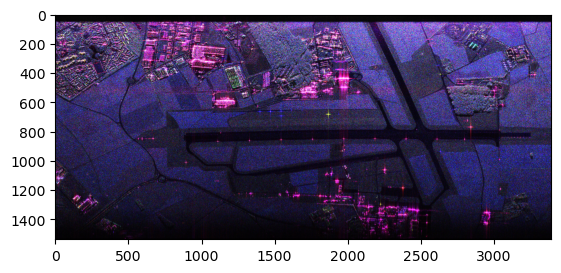

In [47]:
new_pauli_filtered = rough_to_pauli(new_filtered_img)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


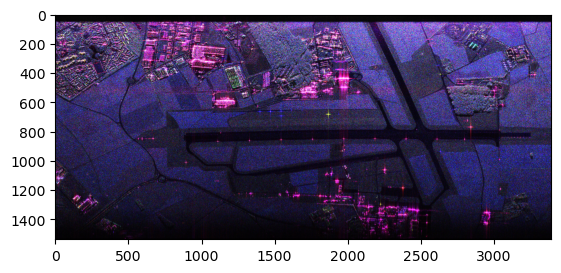

In [48]:
plt.imshow(abs(new_pauli_filtered))

In [ ]:
#two different methods for selecting key pixels one computes the gradient of the image(includes local max and local min) while the other is just about maximums
def img_gradient(img):
    img_gradient = np.zeros(img.shape)
    
    
def local_max():

In [ ]:
#Code implementing article 10.1109/JSTARS.2017.2743338
def key_pixel_selection(img, window_size) :
    key_pixels = []
    non_key_pixels = []
    height, length, dim = img.shape
    w_height, w_length = window_size
    for i in range(0, height, w_height ) :
        for j in range(0, length, w_length) :
            top = max(0, i - w_height // 2)
            bottom = min(height, i + w_height // 2)
            left = max( 0, j - w_length // 2)
            right = min(length, j + w_length // 2)
            np.argmax()

    
    return key_pixels, non_key_pixels

In [20]:
def to_gray_scale(img) :
    height, length, dim = img.shape
    gray_img = np.zeros_like(img, dtype= float)
    for i in range(height) :
        for j in range(length) :
            gray_img[i,j] = [abs(np.conjugate(img[i,j])@img[i,j].T)]*3
    return gray_img

In [21]:
gray_new_img = to_gray_scale(new_img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


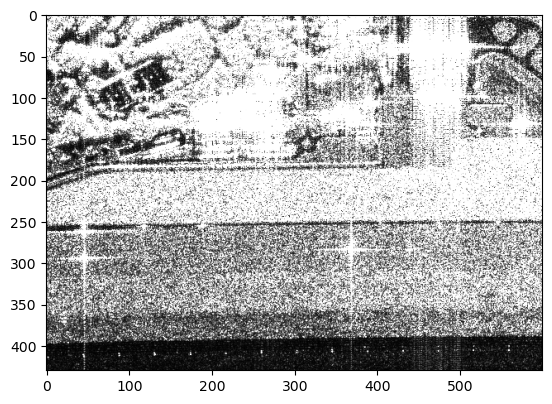

In [22]:
plt.imshow(gray_new_img)